In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax, TypeFamilies #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2020 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
:opt svg
import Language.Stochaskell.Plot

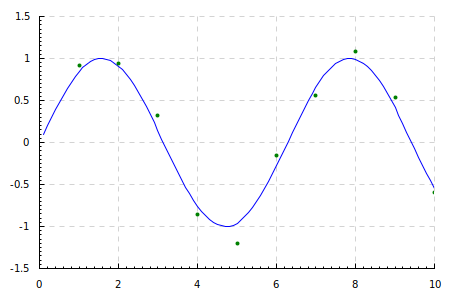

In [3]:
let t = 10
let xTest = [i/10 | i <- [1..100]] :: [Double]
let xData = [1..10] :: [Double]
yData <- map real <$> sequence [simulate (normal (sin (real x)) 0.1 :: P R) | x <- xData]
toRenderable $ do
  plot $ line "" [xTest `zip` (sin <$> xTest)]
  plot $ points "" $ xData `zip` list yData

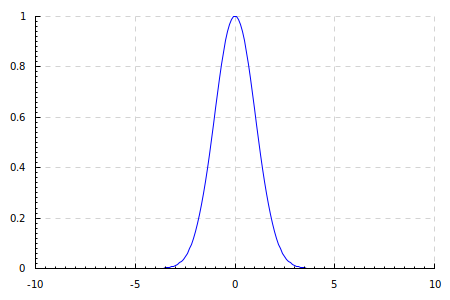

In [4]:
cov ils x y = exp (- ((x - y) * ils)^2 / 2)

let covTest = linspace (-t,t) 200
toRenderable . plot $ line "" [zip covTest $ cov 1 0 <$> covTest]

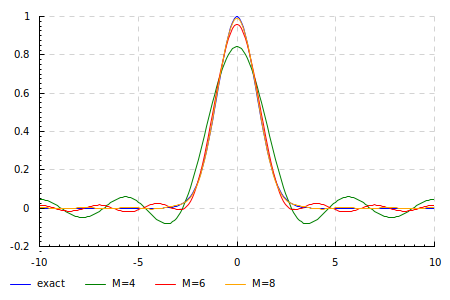

In [5]:
-- equivalent to `cov` fn for m -> infinity
covApprox :: R -> Z -> P R -> R -> R -> R
covApprox t m sd x y = amp 0 + 2 * sum' v where
  amp j = pdf sd (j / (2*t)) / (2*t)
  v = vector [ let w = 2*pi * (x - y) * cast j / (2*t)
               in amp (cast j) * cos w
             | j <- 1...m ]

toRenderable $ do
  plot $ line "exact" [zip covTest $ cov 1 0 <$> covTest]
  let sd = normal 0 (1 / (2*pi))
  sequence [plot $ line ("M="++ show m) [zip covTest $ real . covApprox t m sd 0 <$> covTest] | m <- [4,6,8]]

In [6]:
-- gp using covApprox can be written as a trig polynomial
gpTrigPoly :: R -> Z -> P R -> R -> RVec -> RVec -> R -> R
gpTrigPoly t m sd z a b x = z * amp 0 + sqrt 2 * sum' v where
  amp j = sqrt $ pdf sd (j / (2*t)) / (2*t)
  v = vector [ let w = 2*pi * x * cast j / (2*t)
               in amp (cast j) * ((a!j) * cos w + (b!j) * sin w)
             | j <- 1...m ]

In [7]:
model :: R -> Z -> Z -> P (R,RVec,RVec,R,R,RVec,RVec)
model t m nData = do
  z <- normal 0 1 :: P R
  a <- normals (vector [ 0 | j <- 1...m ]) (vector [ 1 | j <- 1...m ]) :: P RVec
  b <- normals (vector [ 0 | j <- 1...m ]) (vector [ 1 | j <- 1...m ]) :: P RVec
  eta <- gamma 1 1
  ils <- gamma 1 1
  xData <- joint vector [ uniform 0 10 | i <- 1...nData ]
  let sd = normal 0 (ils / (2*pi))
      y i = eta * gpTrigPoly t m sd z a b (xData!i)
  yData <- joint vector [ normal (y i) 0.1 | i <- 1...nData ]
  return (z,a,b,eta,ils,xData,yData)

In [8]:
let t = 10
    m = 20
    nData = 10
z0 <- real <$> (normal 0 1 :: IO Double) :: IO R
a0 <- fromList <$> sequence [ normal 0 1 | _ <- [1..integer m] ] :: IO RVec
b0 <- fromList <$> sequence [ normal 0 1 | _ <- [1..integer m] ] :: IO RVec
let eta0 = 1
    ils0 = 10 / t
samples <- hmcStanInit 1000
    [ (z',a',b',eta',ils')
    | (z',a',b',eta',ils',xData',yData') <- model t m nData
    , xData' == list xData, yData' == list yData
    ] (z0,a0,b0,eta0,ils0)

--- Generating Stan code ---
functions {
  // https://github.com/stan-dev/stan/issues/452
  real to_real(real x) { return x; }
}
data {
  
  
  
  
  
  vector[10] x_stan_0_5;
  vector[10] x_stan_0_6;
}
parameters {
  real x_stan_0_0;
  vector[20] x_stan_0_1;
  vector[20] x_stan_0_2;
  real x_stan_0_3;
  real x_stan_0_4;
  
  
}
model {
  
  
  
  real v_0_3;
  real v_0_4;
  real v_0_5;
  real v_0_6;
  real v_0_7;
  real v_0_8;
  
  
  
  vector[20] v_0_12;
  vector[20] v_0_13;
  
  
  
  v_0_3 = to_real(x_stan_0_4) ./ to_real(6.283185307179586);
  v_0_4 = normal_lpdf(0 | 0, v_0_3);
  v_0_5 = exp(v_0_4);
  v_0_6 = to_real(v_0_5) ./ to_real(20);
  v_0_7 = sqrt(v_0_6);
  v_0_8 = x_stan_0_0 .* v_0_7;
  
  
  
  for (i_1_1 in 1:20) {
  
    v_0_12[i_1_1] = 0;
  }
  for (i_1_1 in 1:20) {
  
    v_0_13[i_1_1] = 1;
  }

  x_stan_0_0 ~ normal(0, 1);
  x_stan_0_1 ~ normal(v_0_12, v_0_13);
  x_stan_0_2 ~ normal(v_0_12, v_0_13);
  x_stan_0_3 ~ gamma(1, 1);
  x_stan_0_4 ~ gamma(1, 1);
  
  for (i_

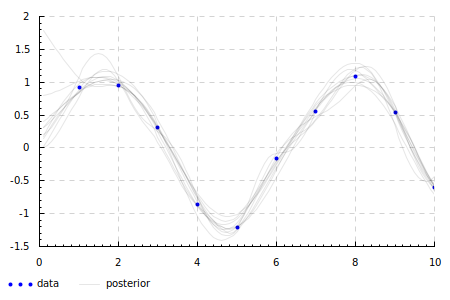

In [9]:
toRenderable $ do
  plot $ points "data" $ sort $ list xData `zip` list (real <$> yData)
  setColors [black `withOpacity` 0.1]
  plot $ line "posterior" [xTest `zip` fTest | (i,(z,a,b,eta,ils)) <- [0..] `zip` samples
                          , i `mod` 100 == 0
                          , let sd = normal 0 (ils / (2*pi))
                                f = real . (eta *) . gpTrigPoly t m sd z a b . real
                                fTest = f <$> xTest :: [Double]
                          ]